# Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

---


# Daniel Shandy Adryan
# 1494037162101-932
# danielshandy34@gmail.com

# Preparation

Importing Libraries and API

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout, BatchNormalization,Bidirectional
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

Declaring variables to simplify the source code

In [2]:
rc=pd.read_csv
bn=BatchNormalization
ss=MinMaxScaler()
tts=train_test_split

Reading the csv-files and fill the NaN data

In [3]:
df = rc('/content/time-series-19-covid-combined.csv', usecols=['Date', 'Confirmed', 'Recovered', 'Deaths'])

df.tail()

,Date,Confirmed,Recovered,Deaths
72085,2020-10-13,8036,7632.0,230
72086,2020-10-14,8055,7640.0,231
72087,2020-10-15,8075,7669.0,231
72088,2020-10-16,8099,7673.0,231
72089,2020-10-17,8110,7673.0,231


Fill the missing data

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

Date         0
Confirmed    0
Recovered    0
Deaths       0
dtype: int64

In [5]:
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15))

72075   2020-10-03
72076   2020-10-04
72077   2020-10-05
72078   2020-10-06
72079   2020-10-07
72080   2020-10-08
72081   2020-10-09
72082   2020-10-10
72083   2020-10-11
72084   2020-10-12
72085   2020-10-13
72086   2020-10-14
72087   2020-10-15
72088   2020-10-16
72089   2020-10-17
Name: Date, dtype: datetime64[ns]


Plotting the dataframe

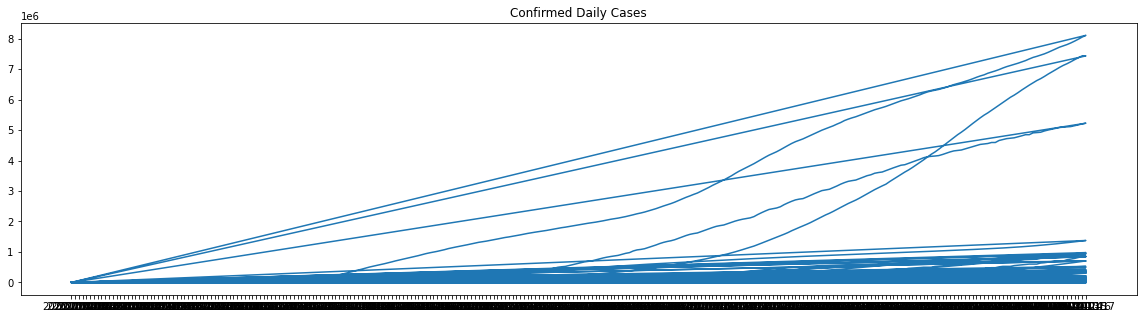

In [6]:
dt = df ['Date'].values
dikonfirmasi = df['Confirmed'].values
 
plt.figure(figsize=(20,5))
plt.plot(dt, dikonfirmasi)
plt.title('Confirmed Daily Cases');

Normalizing the data

In [7]:
mm_scaler = ss.fit_transform(dikonfirmasi.reshape(-1,1))
dk_scaled = mm_scaler.reshape(-1)

Calculating the Threshold for mae

In [8]:
threshold = (dk_scaled.max() - dk_scaled.min()) * 10/100
threshold

0.1

# Modelling and Training

define the function for creating datasets datasets

In [9]:
dt_train, dt_test, dk_train, dk_test = tts(dt, dk_scaled, test_size=0.2, shuffle=False)

In [10]:
def wds(ser, win_size, batch_size, shuffle_buffer):
    ser = tf.expand_dims(ser, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(ser)
    ds = ds.window(win_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(win_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Modelling

In [11]:
traindata = wds(dk_train, win_size=70, batch_size=10, shuffle_buffer=1000)
vd = wds(dk_test, win_size=70, batch_size=10, shuffle_buffer=1000)
model = tf.keras.models.Sequential()
model.add(LSTM(70, return_sequences=True))
model.add(LSTM(70))
model.add(Dense(32, activation='relu'))
model.add(bn())
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(bn())
model.add(Dropout(0.1))
model.add(Dense(1))

Printing Number of samples in a datasets

In [12]:
print('train sample :\n', len(list(traindata)))
print('val sample :\n', len(list(vd)))

train sample :
 5761
val sample :
 1435


Training

In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
train = model.fit(traindata, steps_per_epoch=20, epochs=60, validation_data=vd)

Epoch 1/60
20/20 [==============================] - 16s 590ms/step - loss: 0.0023 - mae: 0.0459 - val_loss: 0.0019 - val_mae: 0.0118
Epoch 2/60
20/20 [==============================] - 8s 439ms/step - loss: 7.9880e-04 - mae: 0.0260 - val_loss: 0.0018 - val_mae: 0.0121
Epoch 3/60
20/20 [==============================] - 8s 438ms/step - loss: 5.8366e-04 - mae: 0.0173 - val_loss: 0.0018 - val_mae: 0.0119
Epoch 4/60
20/20 [==============================] - 8s 440ms/step - loss: 0.0022 - mae: 0.0240 - val_loss: 0.0017 - val_mae: 0.0111
Epoch 5/60
20/20 [==============================] - 8s 440ms/step - loss: 0.0351 - mae: 0.1571 - val_loss: 0.0016 - val_mae: 0.0180
Epoch 6/60
20/20 [==============================] - 8s 439ms/step - loss: 0.0175 - mae: 0.0951 - val_loss: 0.0016 - val_mae: 0.0157
Epoch 7/60
20/20 [==============================] - 10s 518ms/step - loss: 0.0063 - mae: 0.0654 - val_loss: 0.0015 - val_mae: 0.0163
Epoch 8/60
20/20 [==============================] - 9s 460ms/step 

# Plotting

Loss Plotting

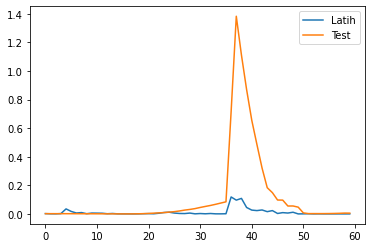

In [14]:
plt.plot(train.history['loss'], label = 'Latih')
plt.plot(train.history['val_loss'], label = 'Test')
plt.legend()

mae Plotting

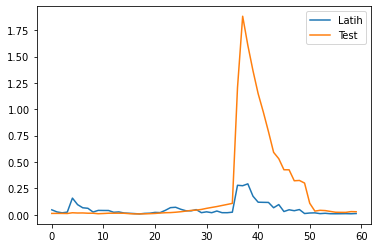

In [15]:
plt.plot(train.history['mae'], label = 'Latih')
plt.plot(train.history['val_mae'], label = 'Test')
plt.legend()